In [1]:
import numpy as np
import healpy as hp
from functools import partial
import matplotlib.pyplot as plt
import pyccl as ccl
import galsim
import torch
from torch.distributions import Normal
from functools import partial

### Option 1: Original interpolation scheme

Pros: We now have a better sense of what values are realistic, and this one is easy to implement. Cons: Shear and convergence aren't consistent with each other here.

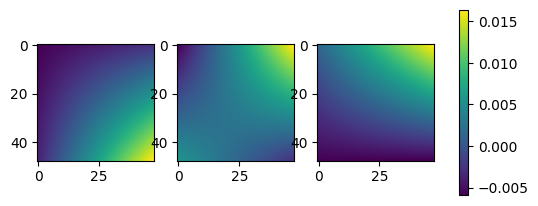

In [2]:
batch_size = 1
n_tiles_h = 48
n_tiles_w = 48
tile_slen = 4
method = "interpolate"
shear_mean = 0
shear_sd = 0.01
convergence_mean = 0
convergence_sd = 0.01
knots = 2

latent_dims = (batch_size, n_tiles_h, n_tiles_w, 2)

# number of knots in each dimension
num_knots = [knots, knots]
corners = (batch_size, num_knots[0], num_knots[1], 2)

shear_maps = Normal(shear_mean, shear_sd).sample(corners)
# want to change from 32 x 20 x 20 x 2 to 32 x 2 x 20 x 20
shear_maps = shear_maps.reshape((batch_size, 2, num_knots[0], num_knots[1]))

shear_maps = torch.nn.functional.interpolate(
    shear_maps,
    scale_factor=(n_tiles_h // num_knots[0], n_tiles_w // num_knots[1]),
    mode="bilinear",
    align_corners=True,
)

# want to change from 32 x 2 x 20 x 20 to 32 x 20 x 20 x 2
shear_maps = torch.swapaxes(shear_maps, 1, 3)
shear_maps = torch.swapaxes(shear_maps, 1, 2)



latent_dims = (batch_size, n_tiles_h, n_tiles_w, 1)
# number of knots in each dimension
num_knots = [knots,knots]
corners = (batch_size, num_knots[0], num_knots[1], 1)
convergence_map = Normal(convergence_mean, convergence_sd).sample(corners)
# want to change from 32 x 20 x 20 x 2 to 32 x 2 x 20 x 20
convergence_map = convergence_map.reshape(
    (batch_size, 1, num_knots[0], num_knots[1])
)

convergence_map = torch.nn.functional.interpolate(
    convergence_map,
    scale_factor=(n_tiles_h // num_knots[0], n_tiles_w // num_knots[1]),
    mode="bilinear",
    align_corners=True,
)

# want to change from 32 x 1 x 20 x 20 to 32 x 20 x 20 x 1
convergence_map = torch.swapaxes(convergence_map, 1, 3)
convergence_map = torch.swapaxes(convergence_map, 1, 2)

fig, ax = plt.subplots(1, 3)
im = ax[0].imshow(shear_maps.squeeze()[:,:,0])
im = ax[1].imshow(shear_maps.squeeze()[:,:,1])
im = ax[2].imshow(convergence_map.squeeze())
fig.colorbar(im, shrink = 0.5, ax = ax)

### Option 2: `pyccl` + `galsim`

This one doesn't seem to vary on the correct scale, and we can't figure out how to get it to do so.

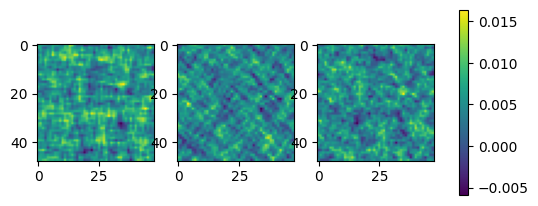

In [3]:
batch_size = 1
n_tiles_h = 48
n_tiles_w = 48
tile_slen = 4
arcsec_per_pixel = 0.396
cosmology = ccl.cosmology.CosmologyVanillaLCDM()


ngrid = n_tiles_w

# ngrid is tiles, convert tiles to pixels, then to arcsecs, and then degrees
grid_size = (ngrid * tile_slen * arcsec_per_pixel) / 3600

# redshift taken from https://github.com/LSSTDESC/CCLX/blob/master/CellsCorrelations.ipynb
z = np.linspace(0., 3., 512)
i_lim = 26. # Limiting i-band magnitude
z0 = 0.0417*i_lim - 0.744

Ngal = 46. * 100.31 * (i_lim - 25.) # Normalisation, galaxies/arcmin^2
pz = 1./(2.*z0) * (z / z0)**2. * np.exp(-z/z0) # Redshift distribution, p(z)
dNdz = Ngal * pz # Number density distribution

lensing_tracer = ccl.WeakLensingTracer(cosmology, dndz=(z, dNdz))

# range of values required by buildGrid
ell = np.arange(1, 100000)

shear_map = torch.zeros((batch_size, n_tiles_h, n_tiles_w, 2))
convergence_map = torch.zeros((batch_size, n_tiles_h, n_tiles_w, 1))
for i in range(batch_size):
    cls = ccl.angular_cl(cosmology, lensing_tracer, lensing_tracer, ell)
    table = galsim.LookupTable(x = ell, f = cls)
    my_ps = galsim.PowerSpectrum(table, units = galsim.degrees)
    g1, g2, kappa = my_ps.buildGrid(grid_spacing=grid_size/ngrid, ngrid=ngrid,
                                    get_convergence=True, units = galsim.degrees)
    gamma1 = g1 * (1 - kappa)
    gamma2 = g2 * (1 - kappa)

    shear_map[i,:,:,0] = torch.from_numpy(gamma1)
    shear_map[i,:,:,1] = torch.from_numpy(gamma2)
    convergence_map[i,:,:,0] =  torch.from_numpy(kappa)

fig, ax = plt.subplots(1,3)
_ = ax[0].imshow(shear_map[0,:,:,0])
_ = ax[1].imshow(shear_map[0,:,:,1])
_ = ax[2].imshow(convergence_map[0,:,:,0])
fig.colorbar(im, shrink = 0.5, ax = ax)

### Option 3: Maps from N-body simulations

From http://cosmo.phys.hirosaki-u.ac.jp/takahasi/allsky_raytracing/. The associated paper is https://iopscience.iop.org/article/10.3847/1538-4357/aa943d/meta. Also used by https://arxiv.org/pdf/2312.08934.pdf.

In [4]:
# input file
filename = '/data/scratch/twhit/allskymap_nres12r000.zs15.mag.dat'

skip = [0, 536870908, 1073741818, 1610612728, 2147483638, 2684354547, 3221225457]
load_blocks = [skip[i+1]-skip[i] for i in range(0, 6)]

with open(filename, 'rb') as f:
    rec = np.fromfile(f, dtype='uint32', count=1)[0]
    nside = np.fromfile(f, dtype='int32', count=1)[0]
    npix = np.fromfile(f, dtype='int64', count=1)[0]
    rec = np.fromfile(f, dtype='uint32', count=1)[0]
    print("nside:{} npix:{}".format(nside, npix))

    rec = np.fromfile(f, dtype='uint32', count=1)[0]

    kappa = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        kappa = np.append(kappa, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            kappa = np.append(kappa, load)

    gamma1 = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        gamma1 = np.append(gamma1, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            gamma1 = np.append(gamma1, load)

    gamma2 = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        gamma2 = np.append(gamma2, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            gamma2 = np.append(gamma2, load)

    omega = np.array([])
    r = npix
    for i, l in enumerate(load_blocks):
        blocks = min(l, r)
        load = np.fromfile(f, dtype='float32', count=blocks)
        np.fromfile(f, dtype='uint32', count=2)
        omega = np.append(omega, load)
        r = r-blocks
        if r == 0:
            break
        elif r > 0 and i == len(load_blocks)-1:
            load = np.fromfile(f, dtype='float32', count=r)
            np.fromfile(f, dtype='uint32', count=2)
            omega = np.append(omega, load)


print('loading completed')

# example of saving data as a fits file
# hp.fitsfunc.write_map('output.fits', kappa)

nside:4096 npix:201326592
loading completed


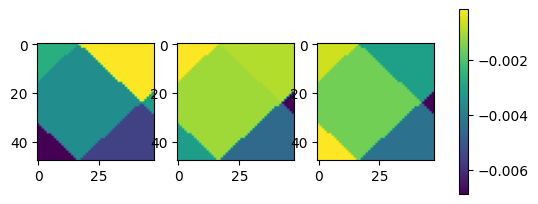

In [5]:
# Get the cutout via a cartesian projection that covers 0.02 x 0.02
loc = np.random.randint(-90, 90)
lonra = [loc, loc+0.02]
loc = np.random.randint(-90, 90)
latra = [loc, loc+0.02]

proj = hp.projector.CartesianProj(
    lonra=lonra, latra=latra,
    coord='C',
    xsize=48, ysize=48)
convergence = proj.projmap(kappa, vec2pix_func=partial(hp.vec2pix, nside))
shear1 = proj.projmap(gamma1, vec2pix_func=partial(hp.vec2pix, nside))
shear2 = proj.projmap(gamma2, vec2pix_func=partial(hp.vec2pix, nside))

# Plot the cutout
fig, ax = plt.subplots(1,3)
im = ax[0].imshow(convergence)
im = ax[1].imshow(shear1)
im = ax[2].imshow(shear2)
fig.colorbar(im, shrink = 0.5, ax = ax)
# plt.imshow(reproj_im + np.random.normal(scale = 1e-5, size = reproj_im.shape), origin='lower', interpolation='nearest')